In [1]:
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats

import ajf_plts

SEED = ajf_plts.get_seed("generate_51_years_freqs.ipynb")

In [2]:
plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

In [3]:
actual_col = "C0"
predict_col = "C6"
train_col = "C3"
valid_col = 'C8'
test_col = "C4"

axvspan_paras = dict(ec="none", fc="grey", zorder=-100)

# Load MIDAS weather data

In [4]:
midas_df = pd.concat(
    [
        pd.read_csv(
            f,
            engine="python",
            skiprows=280,
            skipfooter=1,
            usecols=["ob_time", "air_temperature"],
            parse_dates=["ob_time"],
            infer_datetime_format=True,
            index_col=["ob_time"],
        ).dropna()
        for f in glob.glob("CEDA_Aldergrove/midas-*.csv")
    ]
).asfreq("1H")

print(midas_df)
midas_df.describe()

                     air_temperature
ob_time                             
1949-01-01 00:00:00              2.2
1949-01-01 01:00:00              2.8
1949-01-01 02:00:00              3.9
1949-01-01 03:00:00              2.2
1949-01-01 04:00:00              1.7
...                              ...
2021-12-31 19:00:00             12.7
2021-12-31 20:00:00             12.9
2021-12-31 21:00:00             12.7
2021-12-31 22:00:00             12.2
2021-12-31 23:00:00             12.2

[639912 rows x 1 columns]


,air_temperature
count,639232.000000
mean,9.174955
std,5.046926
min,-14.900000
25%,5.600000
50%,9.200000
75%,12.800000
max,29.800000


## Fill in missing values

In [5]:
print(midas_df[midas_df.isna().values])

                     air_temperature
ob_time                             
1951-06-01 00:00:00              NaN
1959-06-24 17:00:00              NaN
1959-10-28 07:00:00              NaN
1974-10-18 00:00:00              NaN
1981-03-09 00:00:00              NaN
...                              ...
2021-10-22 14:00:00              NaN
2021-10-22 16:00:00              NaN
2021-10-22 17:00:00              NaN
2021-10-22 18:00:00              NaN
2021-10-22 19:00:00              NaN

[680 rows x 1 columns]


In [6]:
midas_df = midas_df.interpolate().reset_index().rename(columns={"ob_time": "time"})
print(midas_df)

                      time  air_temperature
0      1949-01-01 00:00:00              2.2
1      1949-01-01 01:00:00              2.8
2      1949-01-01 02:00:00              3.9
3      1949-01-01 03:00:00              2.2
4      1949-01-01 04:00:00              1.7
...                    ...              ...
639907 2021-12-31 19:00:00             12.7
639908 2021-12-31 20:00:00             12.9
639909 2021-12-31 21:00:00             12.7
639910 2021-12-31 22:00:00             12.2
639911 2021-12-31 23:00:00             12.2

[639912 rows x 2 columns]


# Load in ARDL model

In [7]:
with open('./ardl_model.pkl', 'rb') as f:
    ardl_model = pickle.load(f)

# Predict Freqs

In [8]:
midas_df

,time,air_temperature
0,1949-01-01 00:00:00,2.2
1,1949-01-01 01:00:00,2.8
2,1949-01-01 02:00:00,3.9
3,1949-01-01 03:00:00,2.2
4,1949-01-01 04:00:00,1.7
...,...,...
639907,2021-12-31 19:00:00,12.7
639908,2021-12-31 20:00:00,12.9
639909,2021-12-31 21:00:00,12.7
639910,2021-12-31 22:00:00,12.2


In [9]:
midas_df['freq'] = ardl_model.predict(start=len(ardl_model.data.exog), end=len(ardl_model.data.exog)+len(midas_df)-1,exog_oos=midas_df.air_temperature)
df = midas_df.set_index('time')

df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# (START_YEAR, MONTH) <= (Y, M) < (END_YEAR, END_MONTH)

END_YEAR = 2022
END_MONTH = 1

START_YEAR = END_YEAR - 61
START_MONTH = 1

start_mask = (df.year > START_YEAR) + (
    (df.year == START_YEAR) * (df.month >= START_MONTH)
)

end_mask = (df.year < END_YEAR) + (
    (df.year == END_YEAR) * (df.month < END_MONTH)
)

mask = start_mask * end_mask

df = df.loc[mask]


In [10]:
df.head(), df.tail()

(                     air_temperature      freq  year  month  day  dayofweek  \
 time                                                                          
 1961-01-01 00:00:00              3.9  5.795619  1961      1    1          6   
 1961-01-01 01:00:00              4.7  5.791108  1961      1    1          6   
 1961-01-01 02:00:00              5.0  5.784058  1961      1    1          6   
 1961-01-01 03:00:00              4.8  5.784858  1961      1    1          6   
 1961-01-01 04:00:00              4.2  5.789826  1961      1    1          6   
 
                      hour  minute  
 time                               
 1961-01-01 00:00:00     0       0  
 1961-01-01 01:00:00     1       0  
 1961-01-01 02:00:00     2       0  
 1961-01-01 03:00:00     3       0  
 1961-01-01 04:00:00     4       0  ,
                      air_temperature      freq  year  month  day  dayofweek  \
 time                                                                          
 2021-12-31 19:00:

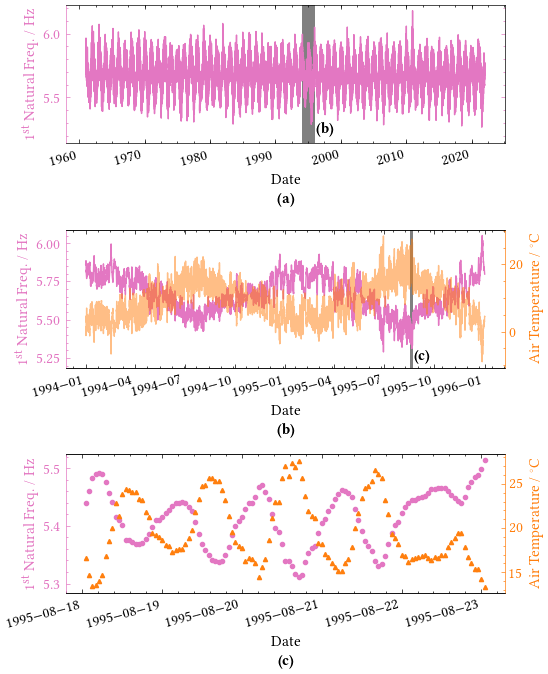

In [11]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 3.0*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=3)

axes2 = [None] + [ax.twinx() for ax in axes[1:]]

props = dict(c=predict_col, rasterized=True)

# OVERALL PLOT
axes[0].plot(df.freq, **props)

# YEAR LEVEL ZOOM
year_start = pd.Timestamp("1994-01-01 00:00:00")
year_end = pd.Timestamp("1995-12-31 23:59:59")
mask = (year_start <= df.index) * (df.index <= year_end)

axes[1].plot(df.freq[mask], **props)
axes2[1].plot(df.air_temperature[mask], c='C1', alpha=0.5)

axes[0].axvspan(year_start, year_end, **axvspan_paras)
axes[0].annotate(
    r"\bfseries (b)",
    xy=(year_end+pd.to_timedelta('90d'), 5.3),
    ha="left",
    va="top",
    fontsize=11.0,
)

# WEEK LEVEL ZOOM
week_start = pd.Timestamp("1995-08-18 01:00:00")
week_end = week_start + pd.Timedelta('5d')
mask = (week_start <= df.index) * (df.index <= week_end)

axes[2].plot(df.freq[mask], **props, ls='', marker='o', markersize=3.0)
#axes2[2].plot(df.air_temperature[mask], c='C1')
axes2[2].plot(df.air_temperature[mask], ls='', marker='^', markersize=3.0, markerfacecolor='C1', markeredgecolor='C1',)

axes[1].axvspan(week_start, week_end, **axvspan_paras)
axes[1].annotate(
    r"\bfseries (c)",
    xy=(week_end+pd.to_timedelta('1d'), 5.3),
    ha="left",
    va="top",
    fontsize=11.0,
)

for ax in axes:
    ax.set_xlabel("Date")
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
    ax.set_ylim(ax.get_ylim() + [-0.08, 0.0] * np.diff(ax.get_ylim()))
    
axes[0].set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}", c=predict_col)
axes[0].tick_params(axis="y", which="both", colors=predict_col)
axes[0].spines["left"].set_color(predict_col)

for ax in axes[1:]:
    ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}", c=predict_col)
    ax.tick_params(axis="y", which="both", colors=predict_col)
    ax.spines["left"].set_color(predict_col)
    ax.spines["right"].set_visible(False)

for ax in axes2[1:]:
    ax.set_ylabel(r"Air Temperature / \unit{\celsius}", c="C1")
    ax.tick_params(axis="y", which="both", colors="C1")
    ax.spines["right"].set_color("C1")
    ax.spines["left"].set_visible(False)
        
ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, 'fig51YearFreqs.pdf')

# Convert f to E

In [12]:
import statsmodels.api as sm

with open('./f_to_E_model.pkl', 'rb') as f:
    ols_model = pickle.load(f)

In [13]:
df['E_val'] = ols_model.predict(sm.add_constant(df.freq))

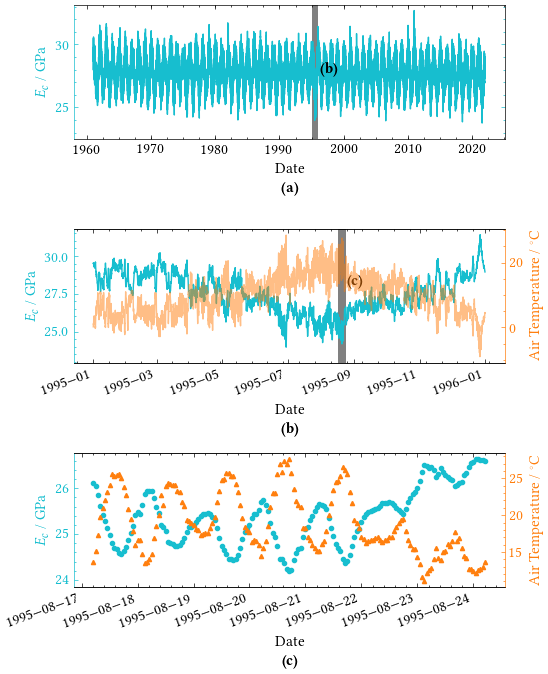

In [14]:
figsize = (ajf_plts.text_width_inches, 3.0*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=3)

axes2 = [None] + [ax.twinx() for ax in axes[1:]]

props = dict(c='C9', rasterized=True)

# OVERALL PLOT
axes[0].plot(df.E_val/1e9, **props)

# YEAR LEVEL ZOOM
year_start = pd.Timestamp("1995-01-01 00:00:00")
year_end = pd.Timestamp("1995-12-31 23:59:59")
mask = (year_start <= df.index) * (df.index <= year_end)

axes[1].plot(df.E_val[mask]/1e9, **props)
axes2[1].plot(df.air_temperature[mask], c='C1', alpha=0.5)

axes[0].axvspan(year_start, year_end, **axvspan_paras)
axes[0].annotate(
    r"\bfseries (b)",
    xy=(year_end+pd.to_timedelta('90d'), 28.5),
    ha="left",
    va="top",
    fontsize=11.0,
)

# WEEK LEVEL ZOOM
week_start = pd.Timestamp("1995-08-17 05:00:00")
week_end = week_start + pd.Timedelta('7d')
mask = (week_start <= df.index) * (df.index <= week_end)

axes[2].plot(df.E_val[mask]/1e9, **props, ls='', marker='o', markersize=3.0)
#axes2[2].plot(df.air_temperature[mask], c='C1')
axes2[2].plot(df.air_temperature[mask], ls='', marker='^', markersize=3.0, markerfacecolor='C1', markeredgecolor='C1',)

axes[1].axvspan(week_start, week_end, **axvspan_paras)
axes[1].annotate(
    r"\bfseries (c)",
    xy=(week_end+pd.to_timedelta('1d'), 28.75),
    ha="left",
    va="top",
    fontsize=11.0,
)

for ax in axes:
    ax.set_xlabel("Date")
    ax.set_ylim(ax.get_ylim() + [-0.08, 0.0] * np.diff(ax.get_ylim()))
    ax.set_ylabel(r"$E_c$ / \unit{\giga\pascal}", c='C9')
    ax.tick_params(axis="y", which="both", colors='C9')
    ax.spines["left"].set_color('C9')

for ax in axes[1:]:
    ax.spines["right"].set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=20, ha="right")

for ax in axes2[1:]:
    ax.set_ylabel(r"Air Temperature / \unit{\celsius}", c="C1")
    ax.tick_params(axis="y", which="both", colors="C1")
    ax.spines["right"].set_color("C1")
    ax.spines["left"].set_visible(False)
        
ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, 'fig51YearsEvals.pdf')

In [15]:
df.loc[df.freq.idxmin()]

air_temperature    2.850000e+01
freq               5.267247e+00
year               2.021000e+03
month              7.000000e+00
day                2.200000e+01
dayofweek          3.000000e+00
hour               1.700000e+01
minute             0.000000e+00
E_val              2.375051e+10
Name: 2021-07-22 17:00:00, dtype: float64

In [16]:
df.loc[df.freq.idxmax()]

air_temperature   -1.320000e+01
freq               6.179613e+00
year               2.010000e+03
month              1.200000e+01
day                2.200000e+01
dayofweek          2.000000e+00
hour               3.000000e+00
minute             0.000000e+00
E_val              3.268198e+10
Name: 2010-12-22 03:00:00, dtype: float64

In [17]:
df.agg(['min', 'mean', 'median', 'max'])

,air_temperature,freq,year,month,day,dayofweek,hour,minute,E_val
min,-14.900000,5.267247,1961.000000,1.00000,1.000000,0.00000,0.0,0.0,2.375051e+10
mean,9.222558,5.669427,1991.000673,6.52298,15.729488,2.99991,11.5,0.0,2.768760e+10
median,9.250000,5.668569,1991.000000,7.00000,16.000000,3.00000,11.5,0.0,2.767920e+10
max,29.800000,6.179613,2021.000000,12.00000,31.000000,6.00000,23.0,0.0,3.268198e+10


In [18]:
df = df.reset_index(drop=True)
df['year'] -= df['year'].min()
df['month'] -= 1
df['seq_month'] = df.loc[:, 'year'] * 12 + df.loc[:, "month"]
df.to_parquet('temp-freq-e_val.parquet')

In [19]:
df

,air_temperature,freq,year,month,day,dayofweek,hour,minute,E_val,seq_month
0,3.9,5.795619,0,0,1,6,0,0,2.892293e+10,0
1,4.7,5.791108,0,0,1,6,1,0,2.887878e+10,0
2,5.0,5.784058,0,0,1,6,2,0,2.880976e+10,0
3,4.8,5.784858,0,0,1,6,3,0,2.881759e+10,0
4,4.2,5.789826,0,0,1,6,4,0,2.886622e+10,0
...,...,...,...,...,...,...,...,...,...,...
534715,12.7,5.597308,60,11,31,4,19,0,2.698160e+10,731
534716,12.9,5.593378,60,11,31,4,20,0,2.694312e+10,731
534717,12.7,5.593709,60,11,31,4,21,0,2.694637e+10,731
534718,12.2,5.598031,60,11,31,4,22,0,2.698868e+10,731
